In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

IMAGE_SHAPE = (224, 224)

# Define the data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\data_AN\train",
    target_size=IMAGE_SHAPE,
    batch_size=64,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\data_AN\val",
    target_size=IMAGE_SHAPE,
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)



Found 4925 images belonging to 6 classes.
Found 120 images belonging to 6 classes.


In [3]:
# Model architecture with regularization
base_model = Xception(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE+(3,))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


77/77 [==============================] - 457s 6s/step - loss: 2.3520 - accuracy: 0.3153 - val_loss: 2.1222 - val_accuracy: 0.3417
Epoch 2/50
77/77 [==============================] - 517s 7s/step - loss: 2.0241 - accuracy: 0.3555 - val_loss: 1.9005 - val_accuracy: 0.4333
Epoch 3/50
77/77 [==============================] - 620s 8s/step - loss: 1.8487 - accuracy: 0.3903 - val_loss: 1.8218 - val_accuracy: 0.3500
Epoch 4/50
77/77 [==============================] - 627s 8s/step - loss: 1.7694 - accuracy: 0.4002 - val_loss: 1.7914 - val_accuracy: 0.4167
Epoch 5/50
77/77 [==============================] - 629s 8s/step - loss: 1.7253 - accuracy: 0.3996 - val_loss: 1.7485 - val_accuracy: 0.3667
Epoch 6/50
77/77 [==============================] - 630s 8s/step - loss: 1.6836 - accuracy: 0.4102 - val_loss: 1.7061 - val_accuracy: 0.4500
Epoch 7/50
77/77 [==============================] - 648s 8s/step - loss: 1.6523 - accuracy: 0.4191 - val_loss: 1.6772 - val_accuracy: 0.4083
Epoch 8/50


In [5]:
# Unfreeze the top layers of the model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
77/77 [==============================] - 806s 10s/step - loss: 1.7595 - accuracy: 0.3492 - val_loss: 1.6676 - val_accuracy: 0.3417
Epoch 2/50
77/77 [==============================] - 767s 10s/step - loss: 1.6368 - accuracy: 0.3984 - val_loss: 1.6269 - val_accuracy: 0.4000
Epoch 3/50
77/77 [==============================] - 762s 10s/step - loss: 1.5620 - accuracy: 0.4325 - val_loss: 1.6097 - val_accuracy: 0.4583
Epoch 4/50
77/77 [==============================] - 773s 10s/step - loss: 1.4958 - accuracy: 0.4556 - val_loss: 1.5609 - val_accuracy: 0.3917
Epoch 5/50
77/77 [==============================] - 763s 10s/step - loss: 1.4552 - accuracy: 0.4739 - val_loss: 1.5155 - val_accuracy: 0.4083
Epoch 6/50
77/77 [==============================] - 768s 10s/step - loss: 1.3973 - accuracy: 0.5056 - val_loss: 1.5775 - val_accuracy: 0.4250
Epoch 7/50
77/77 [==============================] - 769s 10s/step - loss: 1.3633 - accuracy: 0.5165 - val_loss: 1.5741 - val_accuracy: 0.4083
Epoch 

In [6]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')


2/2 [==============================] - 21s 8s/step - loss: 1.4285 - accuracy: 0.5500
Validation Loss: 1.4284589290618896
Validation Accuracy: 0.550000011920929


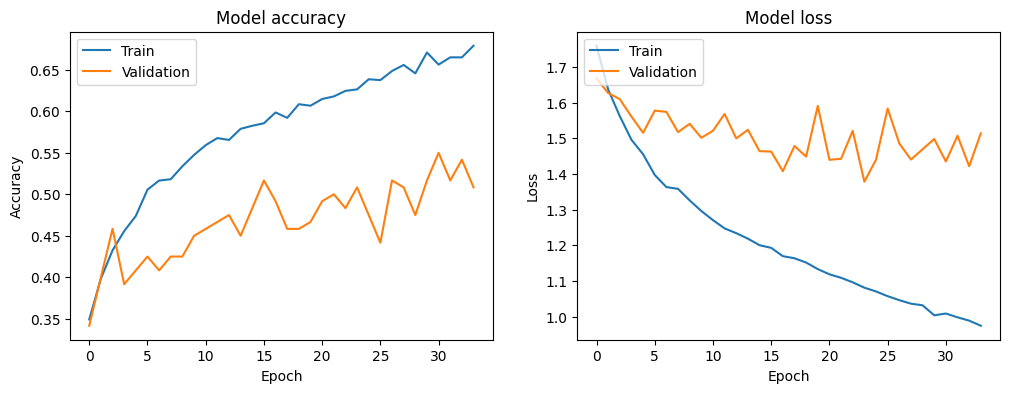

In [7]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

plot_history(history_fine)


In [8]:
# Testing
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    r"C:\Users\User\OneDrive\Desktop\EmoSense\Face Emotion Recognition\data_AN\test",
    target_size=IMAGE_SHAPE,
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2400 images belonging to 6 classes.


In [9]:
import numpy as np
# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Extract the true labels from the test generator
y_test = test_generator.classes

# Calculate the accuracy using the custom function
def accuracy(A):
    count = 0
    y_t = y_test[0:A.size]  # Adjust range as necessary
    for i in range(A.size):
        if A[i] == y_t[i]:
            count += 1
    acc = (count / A.size) * 100
    return acc

acc = accuracy(predicted_classes)
print(f'Accuracy: {acc:.2f}%')


75/75 [==============================] - 274s 4s/step
Accuracy: 48.58%


In [10]:
# Assuming 'model' is your trained model
model.save('new_model_AN.h5')  # You can use .h5 or no extension for SavedModel format


C:\Users\User\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
